In [1]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import seaborn as sns
import torch.nn as nn
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [2]:
def torch_train_test_split(*tensors, split=.8):
    n_samples = tensors[0].shape[0]
    train_size = int(split * n_samples)
    test_size = n_samples - train_size
    rand_indices = torch.randperm(n_samples)
    train_indices, test_indices = torch.split(rand_indices, [train_size, test_size])
    assert train_indices.shape[0] == train_size, f'{train_indices.shape} != {train_size}'
    assert test_indices.shape[0] == n_samples - train_size, f'{test_indices.shape} != {n_samples - train_size}'

    data_tensors = list()
    for tensor in tensors:
        assert tensor.shape[0] == n_samples
        train_data = tensor[train_indices]
        test_data = tensor[test_indices]
        data_tensors.extend((train_data, test_data))
    return data_tensors

def torch_data_from_noisy_generators(dataset_generators):
    tensors = list()
    for dataset_generator in dataset_generators:
        # convert this from arr to tensor after numpy change
        original_arr = dataset_generator.samples
        denoised_arr = dataset_generator.wave
        assert original_arr.shape == denoised_arr.shape, f'{original_arr.shape} != {denoised_arr.shape}'
        original_tensor = torch.from_numpy(original_arr)
        denoised_tensor = torch.from_numpy(denoised_arr)
        tensors.append((original_tensor, denoised_tensor))
            
    original_tensors, denoised_tensors = zip(*tensors)
    original_tensor = torch.cat(original_tensors, dim=0).unsqueeze(axis=1).double()
    denoised_tensor = torch.cat(denoised_tensors, dim=0).double()
    return original_tensor, denoised_tensor
    
class TorchDenoisingDataset(Dataset):
    def __init__(self, input_tensor, output_tensor):
        assert input_tensor.shape[0] == output_tensor.shape[0], f'{input_tensor.shape} != {output_tensor.shape[0]}'
        self._original = input_tensor
        self._denoised = output_tensor
        return
    
    @property
    def shape(self):
        return self._original.shape

    def __len__(self):
        return self._original.shape[0]

    def __getitem__(self, index):
        original = self._original[index]
        denoised = self._denoised[index]
        return original, denoised

In [3]:
large_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.5).t_noise(std=.01, dof=5)
small_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.05).t_noise(std=.01, dof=5)
flat_wave_gen = WaveGen(size=1_000).linear_phase().cos().amp(.005).t_noise(std=.01, dof=5)

dataset_samples = 10_000
dataset_generators = [
    large_wave_gen.sample(dataset_samples),
    small_wave_gen.sample(dataset_samples),
    flat_wave_gen.sample(dataset_samples),
]

In [4]:
original, denoised = torch_data_from_noisy_generators(dataset_generators)
train_original, test_original, train_denoised, test_denoised = torch_train_test_split(original, denoised, split=.8)

train_dataset = TorchDenoisingDataset(train_original, train_denoised)
test_dataset = TorchDenoisingDataset(test_original, test_denoised)

In [5]:
class SineDAE(nn.Module):
    def __init__(
        self, 
        input_size, 
        out_channels=16, 
        kernel_size=2, 
        stride=4, 
        pool_kernel=4, 
        drop=.4, 
        alpha=.2,
    ):
        super(SineDAE, self).__init__()
        conv1_shape = (input_size - kernel_size) // stride + 1
        pool_shape = (conv1_shape - pool_kernel) // pool_kernel + 1
        conv1t_shape = (out_channels - 1) * stride + (kernel_size - 1) + 1
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=out_channels, kernel_size=kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.MaxPool1d(kernel_size=pool_kernel),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(pool_shape, 1, kernel_size, stride=stride),
            nn.LeakyReLU(negative_slope=alpha),
            nn.Linear(conv1t_shape, input_size + 1),
        )
    
        print(self.decoder[0])
    
        return
        
    def forward(self, x):
        x_enc = self.encoder(x)
#         display(x_enc.shape)
        x_enc = x_enc.transpose(1, 2)
#         display(x_enc.shape)
        x_dec = self.decoder(x_enc).squeeze(dim=1)
        return x_dec

In [6]:
def train(
    model, 
    train_dataset, 
    test_dataset, 
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
    print_=False,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        p = print_ & True
        for (train_original, train_denoised), (test_original, test_denoised) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_output = model(train_original)
            
            assert train_output.shape == train_denoised.shape, f'{train_output.shape} != {train_denoised.shape}'
            train_loss = criterion(train_output, train_denoised)       
            train_loss.backward()
            optimizer.step()

            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)

            if p and not epoch % 10:
                print('Train Loss', train_loss.item())
                print('Test Loss', test_loss.item())
                p = False
                
        if test_full:
            train_original, train_denoised = train_dataset[:]
            test_original, test_denoised = test_dataset[:]
            train_output = model(train_original)
            train_loss = criterion(train_output, train_denoised)
            test_output = model(test_original)
            test_loss = criterion(test_output, test_denoised)
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(items, title='', step=1):
    plt.figure(figsize=(16,8))
    train_loss, test_loss = zip(*items)
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[3], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
out_channelss = [2,4,8]
kernel_sizes = [16,32,48,64]
strides = [1,2,4,8,None]
pool_kernels = [2,4,8,16]

total_i = np.prod((len(out_channelss), len(kernel_sizes), len(strides), len(pool_kernels)))

columns = ['out_channels','kernel_size','stride','pool_kernel','train_loss','test_loss']
rows = list()
n_epochs = 30
batch_size = 128
for i, (out_channels, kernel_size, stride, pool_kernel) in enumerate(itertools.product(out_channelss, kernel_sizes, strides, pool_kernels)):
    if stride is None:
        stride = kernel_size
    if stride > kernel_size or stride > pool_kernel:
        continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(out_channels, kernel_size, stride, pool_kernel, sep='|')
    
    model = SineDAE(
        train_dataset.shape[2] - 1,
        out_channels=out_channels,
        kernel_size=kernel_size,
        stride=stride,
        pool_kernel=pool_kernel,
    ).double()
    
    try:
        model, items = train(
            model, 
            train_dataset, 
            test_dataset, 
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(items):
        print('Missing loss')
        continue
    train_loss, test_loss = zip(*items)
    train_loss = np.mean(train_loss[2:])
    test_loss = np.mean(test_loss[2:])
    
    rows.append((out_channels, kernel_size, stride, pool_kernel, train_loss, test_loss))

Input Set 1 out of 240
2|16|1|2
ConvTranspose1d(492, 1, kernel_size=(16,), stride=(1,))
Input Set 2 out of 240
2|16|1|4
ConvTranspose1d(246, 1, kernel_size=(16,), stride=(1,))


C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Input Set 3 out of 240
2|16|1|8
ConvTranspose1d(123, 1, kernel_size=(16,), stride=(1,))
Input Set 4 out of 240
2|16|1|16
ConvTranspose1d(61, 1, kernel_size=(16,), stride=(1,))
Input Set 5 out of 240
2|16|2|2
ConvTranspose1d(246, 1, kernel_size=(16,), stride=(2,))
Input Set 6 out of 240
2|16|2|4
ConvTranspose1d(123, 1, kernel_size=(16,), stride=(2,))
Input Set 7 out of 240
2|16|2|8
ConvTranspose1d(61, 1, kernel_size=(16,), stride=(2,))
Input Set 8 out of 240
2|16|2|16
ConvTranspose1d(30, 1, kernel_size=(16,), stride=(2,))
Input Set 10 out of 240
2|16|4|4
ConvTranspose1d(61, 1, kernel_size=(16,), stride=(4,))
Input Set 11 out of 240
2|16|4|8
ConvTranspose1d(30, 1, kernel_size=(16,), stride=(4,))
Missing loss
Input Set 12 out of 240
2|16|4|16
ConvTranspose1d(15, 1, kernel_size=(16,), stride=(4,))
Missing loss
Input Set 15 out of 240
2|16|8|8
ConvTranspose1d(15, 1, kernel_size=(16,), stride=(8,))
Input Set 16 out of 240
2|16|8|16
ConvTranspose1d(7, 1, kernel_size=(16,), stride=(8,))
Missin

C:\Users\Nick\AppData\Local\Temp\ipykernel_25420\2643065284.py:40: UserWarning: Given transposed=1, weight of size [14, 1, 48], expected input[128, 15, 2] to have 14 channels, but got 15 channels instead
  warnings.warn(str(re))


Input Set 56 out of 240
2|48|8|16
ConvTranspose1d(7, 1, kernel_size=(48,), stride=(8,))
Input Set 61 out of 240
2|64|1|2
ConvTranspose1d(468, 1, kernel_size=(64,), stride=(1,))
Input Set 62 out of 240
2|64|1|4
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(1,))
Input Set 63 out of 240
2|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 64 out of 240
2|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 65 out of 240
2|64|2|2
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(2,))
Input Set 66 out of 240
2|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 67 out of 240
2|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 68 out of 240
2|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 70 out of 240
2|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 71 out of 240
2|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))
Input Set 72 out of 240
2

C:\Users\Nick\AppData\Local\Temp\ipykernel_25420\2643065284.py:40: UserWarning: Given transposed=1, weight of size [14, 1, 48], expected input[128, 15, 4] to have 14 channels, but got 15 channels instead
  warnings.warn(str(re))


Input Set 141 out of 240
4|64|1|2
ConvTranspose1d(468, 1, kernel_size=(64,), stride=(1,))
Input Set 142 out of 240
4|64|1|4
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(1,))
Input Set 143 out of 240
4|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 144 out of 240
4|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 145 out of 240
4|64|2|2
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(2,))
Input Set 146 out of 240
4|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 147 out of 240
4|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 148 out of 240
4|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 150 out of 240
4|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 151 out of 240
4|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))
Input Set 152 out of 240
4|64|4|16
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(4,))
Input Set 155

C:\Users\Nick\AppData\Local\Temp\ipykernel_25420\2643065284.py:40: UserWarning: Given transposed=1, weight of size [14, 1, 48], expected input[128, 15, 8] to have 14 channels, but got 15 channels instead
  warnings.warn(str(re))


Input Set 221 out of 240
8|64|1|2
ConvTranspose1d(468, 1, kernel_size=(64,), stride=(1,))
Input Set 222 out of 240
8|64|1|4
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(1,))
Input Set 223 out of 240
8|64|1|8
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(1,))
Input Set 224 out of 240
8|64|1|16
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(1,))
Input Set 225 out of 240
8|64|2|2
ConvTranspose1d(234, 1, kernel_size=(64,), stride=(2,))
Input Set 226 out of 240
8|64|2|4
ConvTranspose1d(117, 1, kernel_size=(64,), stride=(2,))
Input Set 227 out of 240
8|64|2|8
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(2,))
Input Set 228 out of 240
8|64|2|16
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(2,))
Input Set 230 out of 240
8|64|4|4
ConvTranspose1d(58, 1, kernel_size=(64,), stride=(4,))
Input Set 231 out of 240
8|64|4|8
ConvTranspose1d(29, 1, kernel_size=(64,), stride=(4,))
Input Set 232 out of 240
8|64|4|16
ConvTranspose1d(14, 1, kernel_size=(64,), stride=(4,))
Input Set 235

In [8]:
grid_df = pd.DataFrame(rows)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,out_channels,kernel_size,stride,pool_kernel,train_loss,test_loss
0,2,16,1,2,0.000357,0.000356
1,2,16,1,4,NaN,NaN
2,2,16,1,8,0.000105,0.000104
3,2,16,1,16,NaN,NaN
4,2,16,2,2,NaN,NaN
...,...,...,...,...,...,...
140,8,64,4,4,0.059252,0.058690
141,8,64,4,8,0.000603,0.000597
142,8,64,4,16,0.000044,0.000044
143,8,64,8,8,0.000037,0.000037


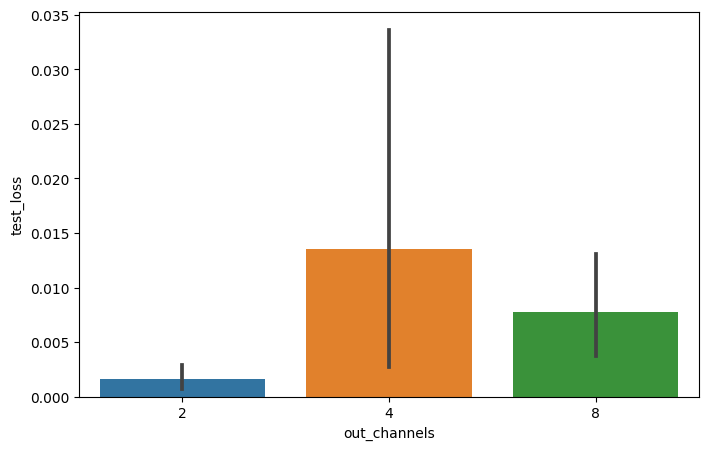

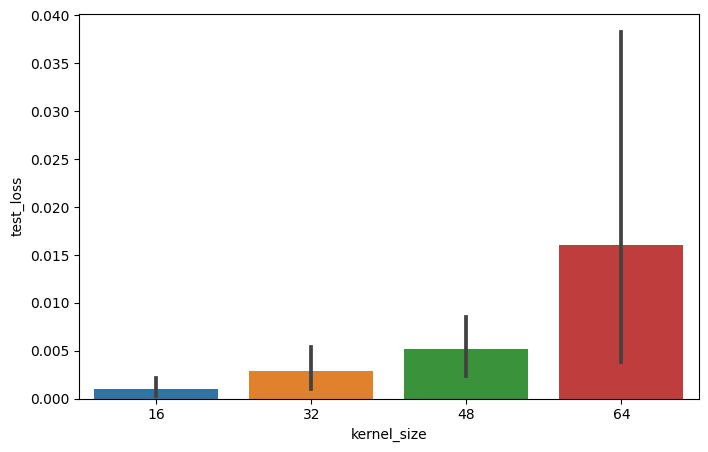

C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
C:\Users\Nick\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


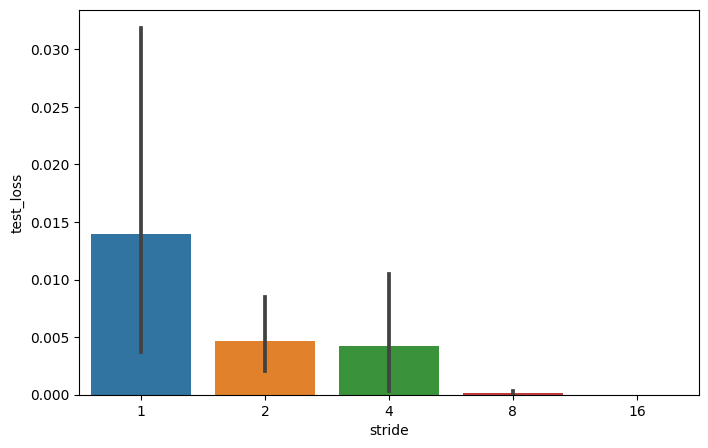

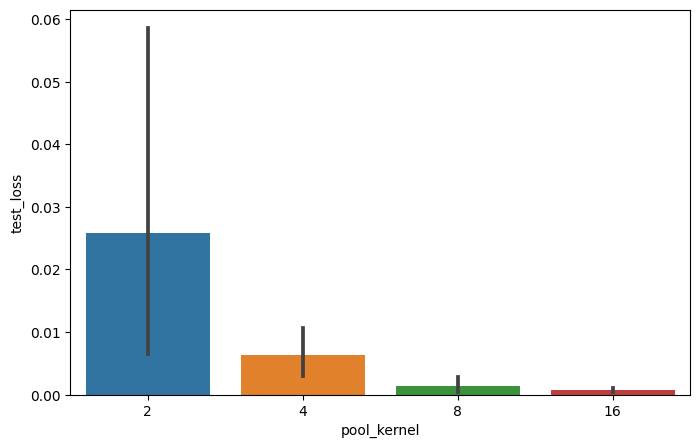

In [9]:
for col in ['out_channels','kernel_size','stride','pool_kernel']:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

ConvTranspose1d(15, 1, kernel_size=(32,), stride=(4,))


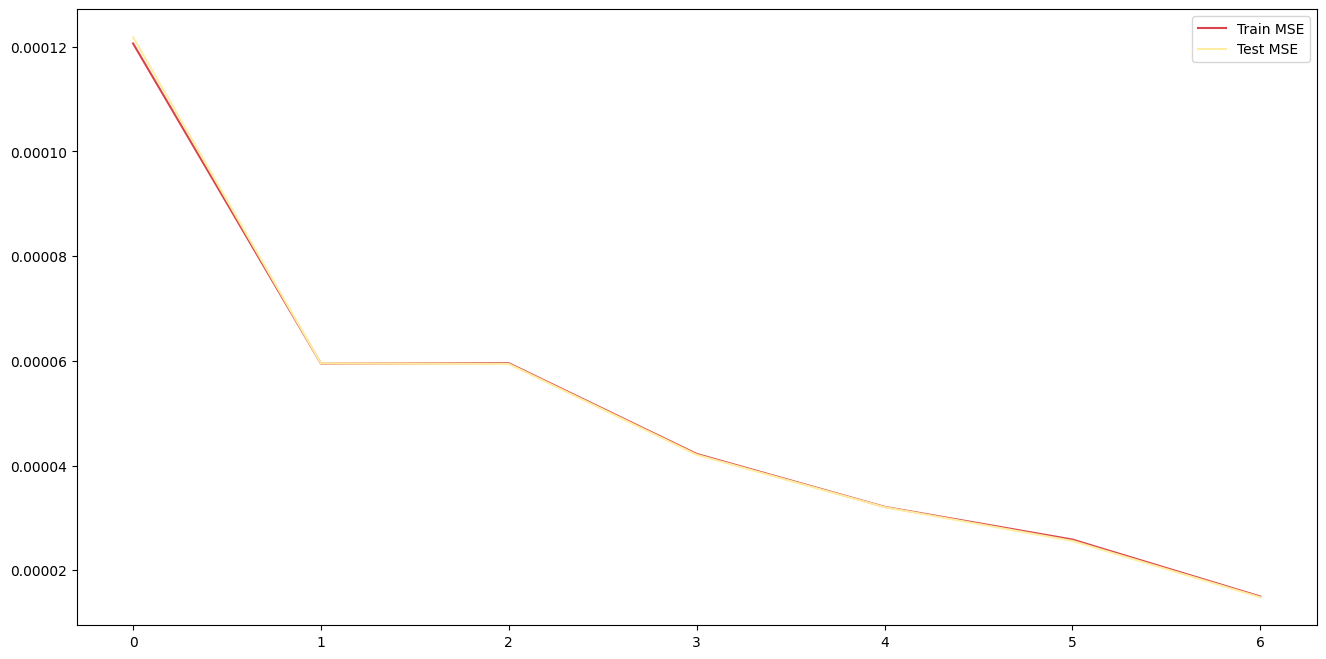

In [10]:
best_out_channels, best_kernel_size, best_stride, best_pool_kernel = grid_df.iloc[grid_df['test_loss'].argmin(),:4].to_numpy(dtype=np.int32)

# display(best_out_channels, best_kernel_size, best_stride, best_pool_kernel)
model = SineDAE(
    train_dataset.shape[2] - 1,
    out_channels=best_out_channels,
    kernel_size=best_kernel_size,
    stride=best_stride,
    pool_kernel=best_pool_kernel,
).double()

model, items = train(model, train_dataset, test_dataset, n_epochs=100, test_full=True, early_stop_patience=30) 
plot_loss(
    items,
    title=''
)
torch.save(model, 'best_dae_model.pt')

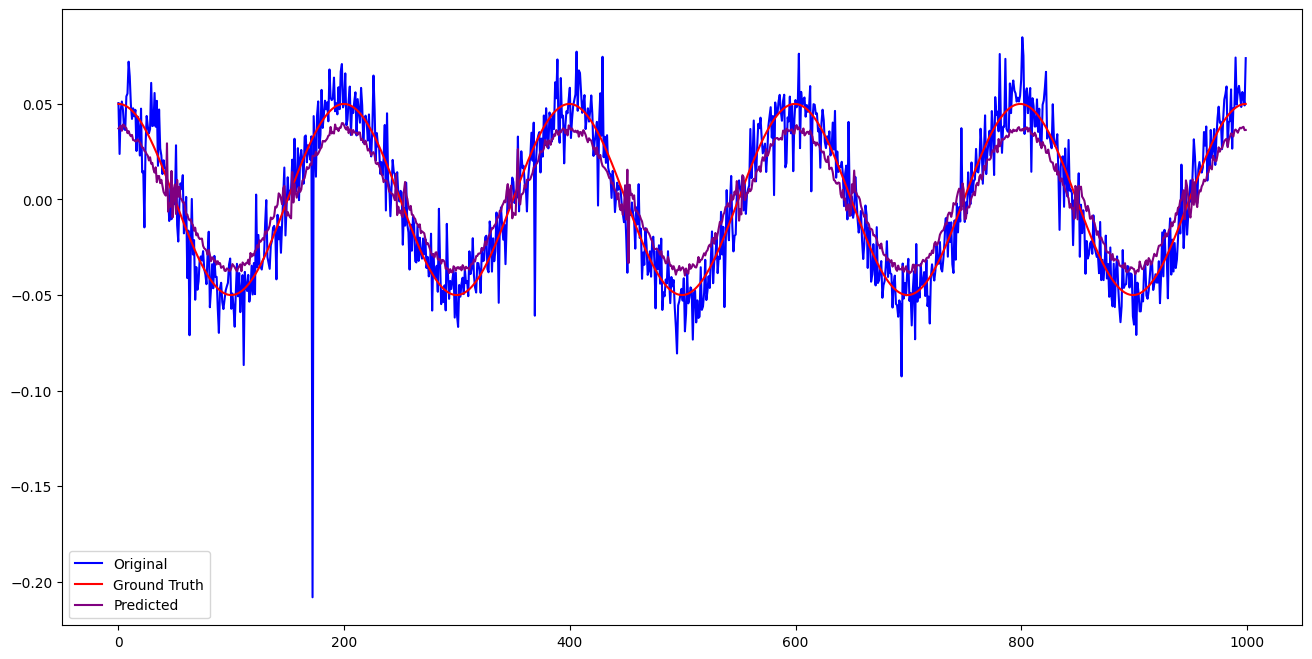

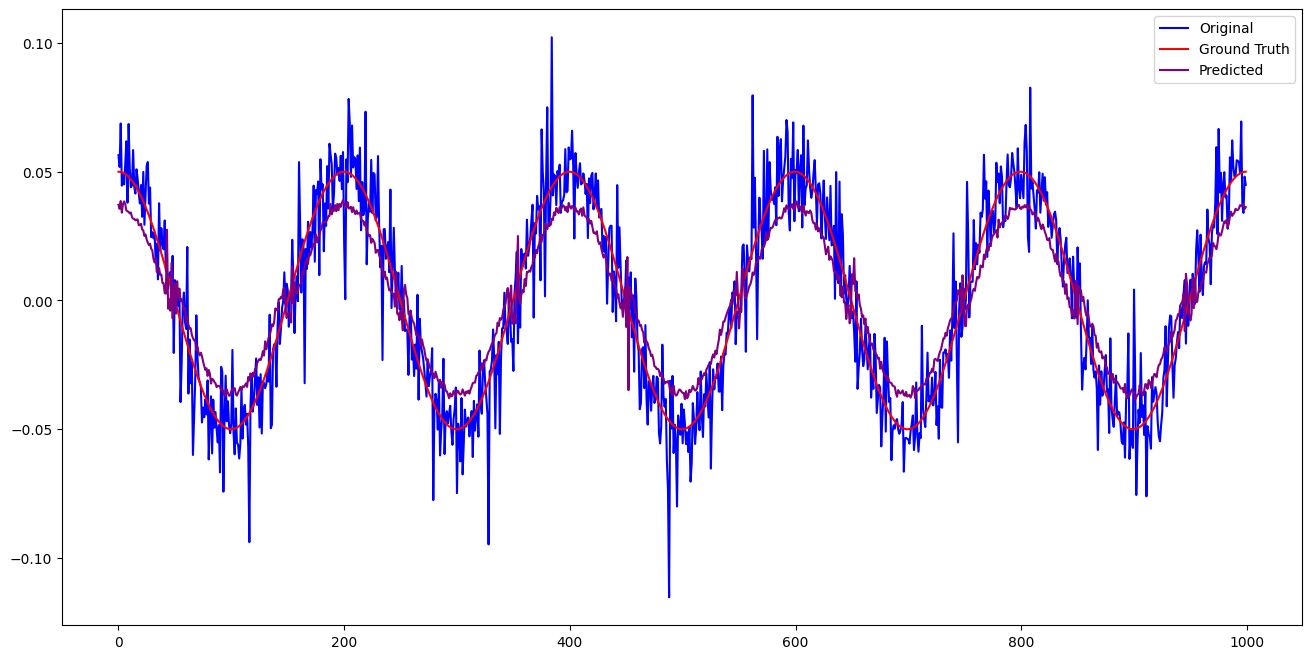

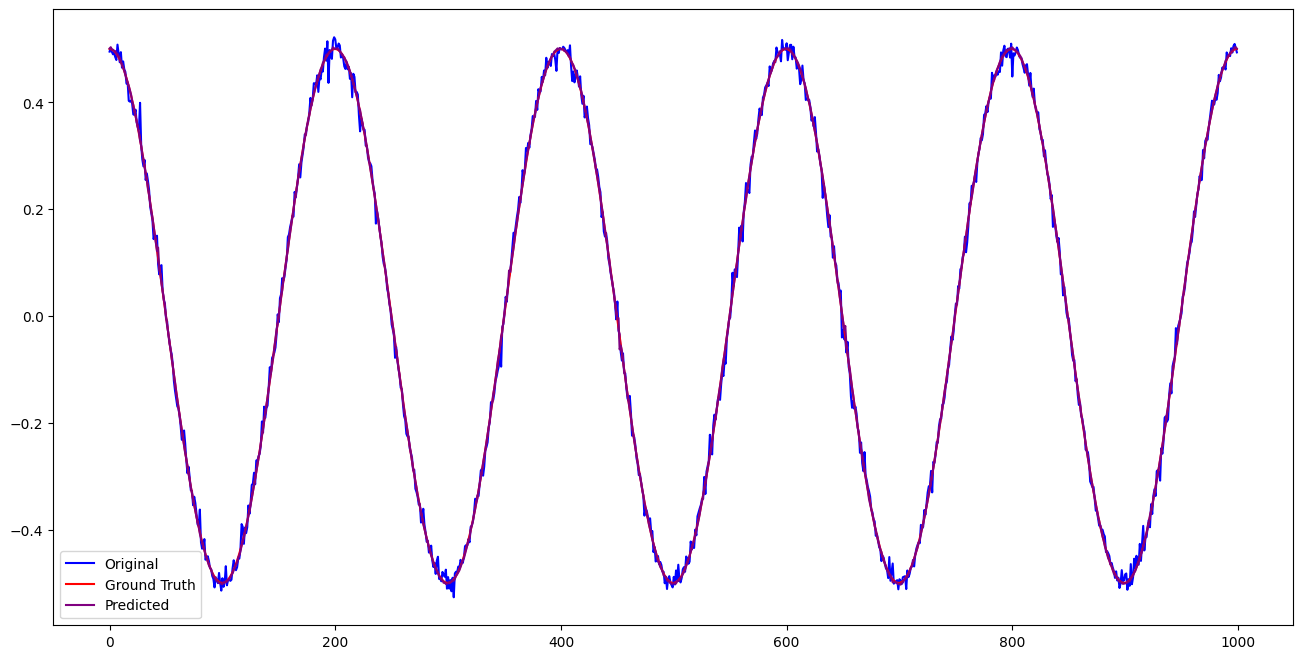

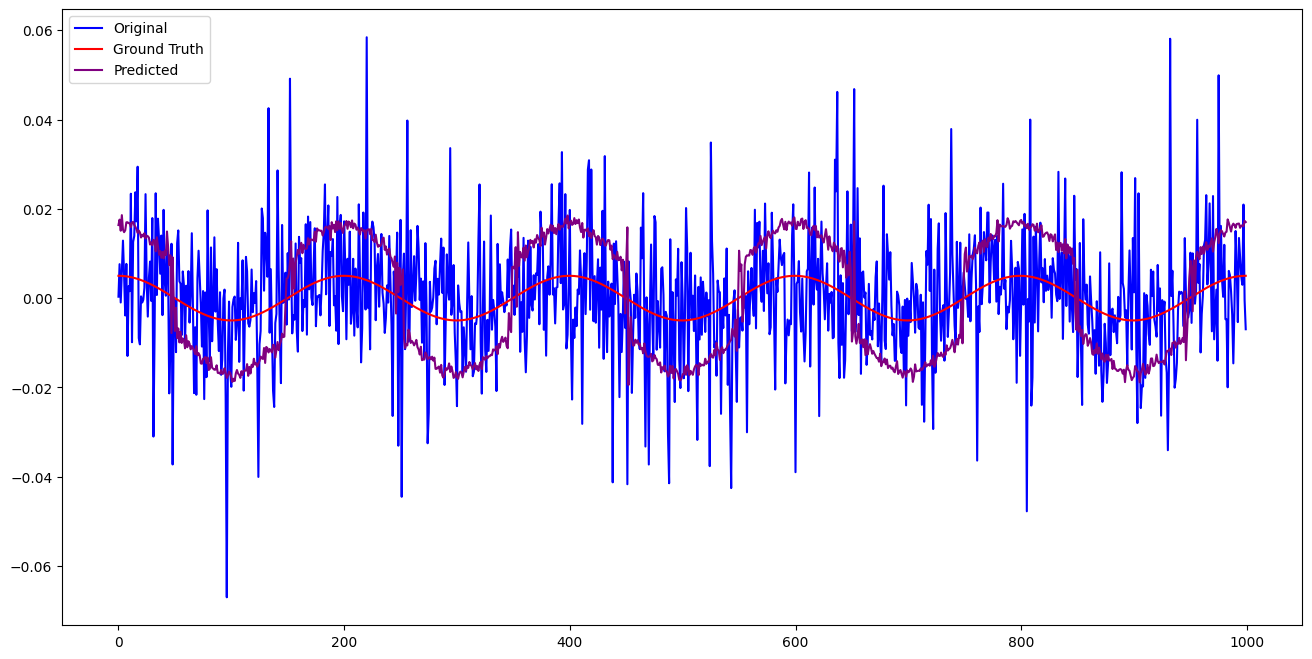

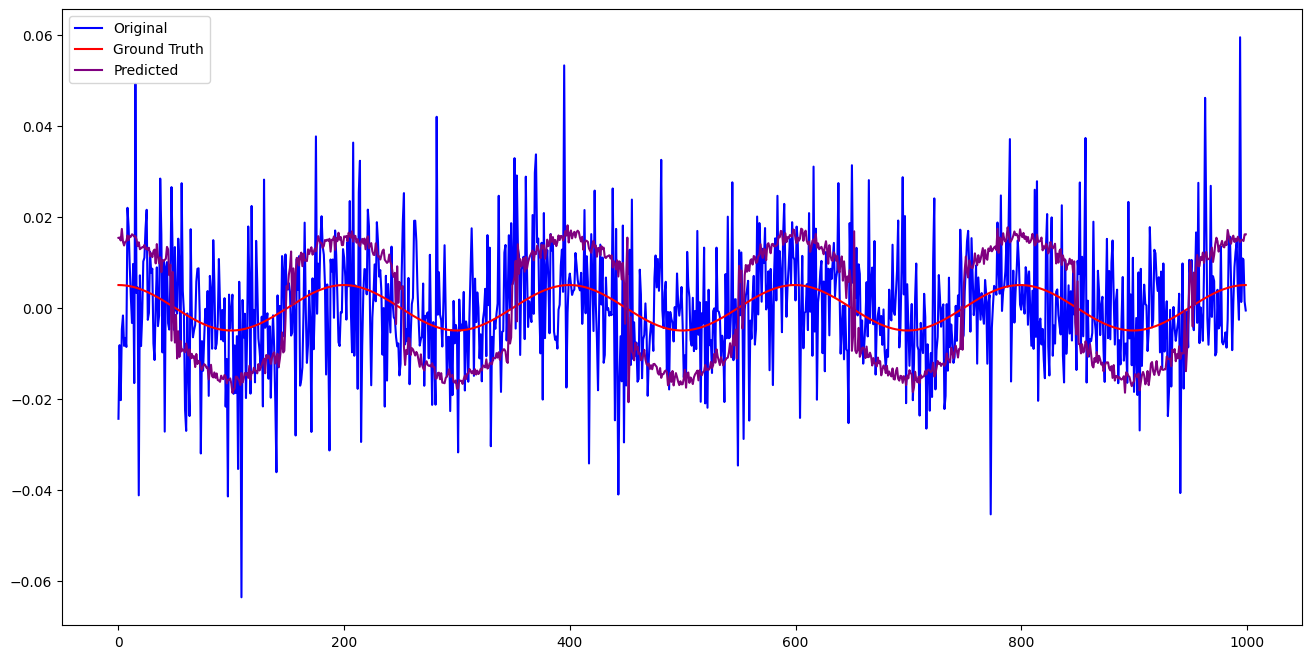

In [11]:
for i in np.random.choice(test_dataset.shape[0], size=5):
    x, y = test_dataset[i]
    
    z = model(x.unsqueeze(dim=1)).detach().numpy().squeeze()
    x = x.squeeze()

    plt.figure(figsize=(16,8))
    plt.plot(x, color='blue', label='Original')
    plt.plot(y, color='red', label='Ground Truth')
    plt.plot(z, color='purple', label='Predicted')
    plt.legend()
    plt.show()